# Noise Robustness Analysis

This notebook generates:
1. Success Rate vs Position Noise bar plot
2. Break Rate vs Position Noise bar plot
3. LaTeX table for nominal performance

In [ ]:
# ============================================================
# BLOCK 1: IMPORTS & CONSTANTS
# ============================================================

import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# WandB Configuration
ENTITY = "hur"
PROJECT = "SG_Exps"

# Method Tags (PLACEHOLDER - update these)
METHOD_TAGS = {
    "Pose": "pose_perf-comp:2026-01-05_10:54",
    "Hybrid-Basic": "basic-hybrid_perf-comp:2026-01-05_10:54",
    "LCLoP": "LCLoP_perf-comp:2026-01-05_10:54",
    #"LCLoP": "LCLoP_fix_perf-comp:2026-01-09_11:17",
}

# Evaluation Tags
TAG_EVAL_PERFORMANCE = "eval_performance"
TAG_EVAL_NOISE = "eval_noise"

# Noise Level Mapping: display label -> metric range string
NOISE_LEVELS = {
    "1mm": "0mm-1mm",
    "2.5mm": "1mm-2.5mm",
    "5mm": "2.5mm-5mm",
    "7.5mm": "5mm-7.5mm",
}

# Metrics
METRIC_SUCCESS = "num_successful_completions"
METRIC_BREAKS = "num_breaks"
METRIC_TOTAL = "total_episodes"
METRIC_TIME = "episode_length"
METRIC_FORCE = "avg_force_in_contact"  # Can change to max_force if needed

In [19]:
# ============================================================
# BLOCK 2: DETERMINE BEST POLICY
# ============================================================

def get_best_checkpoint_per_run(api, method_tag):
    """Find the best checkpoint for each run with the given method tag."""
    runs = api.runs(
        f"{ENTITY}/{PROJECT}",
        filters={"$and": [{"tags": method_tag}, {"tags": TAG_EVAL_PERFORMANCE}]}
    )
    
    best_checkpoints = {}
    for run in runs:
        history = run.history()
        if history.empty:
            print(f"Warning: Run {run.name} has no history data")
            continue
        
        # Calculate score: successes - breaks
        history["score"] = history[f"Eval_Core/{METRIC_SUCCESS}"] - history[f"Eval_Core/{METRIC_BREAKS}"]
        best_idx = history["score"].idxmax()
        best_step = int(history.loc[best_idx, "total_steps"])
        
        best_checkpoints[run.id] = {
            "run_name": run.name,
            "best_step": best_step,
            "score": history.loc[best_idx, "score"],
        }
        print(f"  {run.name}: best checkpoint at step {best_step} (score: {history.loc[best_idx, 'score']:.0f})")
    
    return best_checkpoints

# Get best checkpoints for each method
api = wandb.Api()
best_checkpoints_by_method = {}

for method_name, method_tag in METHOD_TAGS.items():
    print(f"\n{method_name} ({method_tag}):")
    best_checkpoints_by_method[method_name] = get_best_checkpoint_per_run(api, method_tag)


Pose (pose_perf-comp:2026-01-05_10:54):
  Eval_performance_pose_perf-comp_f(10)_0: best checkpoint at step 1228800 (score: 95)
  Eval_performance_pose_perf-comp_f(10)_1: best checkpoint at step 1536000 (score: 97)
  Eval_performance_pose_perf-comp_f(10)_3: best checkpoint at step 1920000 (score: 91)
  Eval_performance_pose_perf-comp_f(10)_4: best checkpoint at step 1113600 (score: 97)
  Eval_performance_pose_perf-comp_f(10)_2: best checkpoint at step 2496000 (score: 96)

Hybrid-Basic (basic-hybrid_perf-comp:2026-01-05_10:54):
  Eval_performance_basic-hybrid_perf-comp_f(10)_0: best checkpoint at step 1420800 (score: 94)
  Eval_performance_basic-hybrid_perf-comp_f(10)_1: best checkpoint at step 2803200 (score: 97)
  Eval_performance_basic-hybrid_perf-comp_f(10)_2: best checkpoint at step 2227200 (score: 96)
  Eval_performance_basic-hybrid_perf-comp_f(10)_3: best checkpoint at step 2534400 (score: 94)
  Eval_performance_basic-hybrid_perf-comp_f(10)_4: best checkpoint at step 2918400 (sco

In [20]:
# ============================================================
# BLOCK 3: DOWNLOAD DATA
# ============================================================

def download_eval_performance_data(api, method_tag, best_checkpoints):
    """Download eval_performance data for best checkpoints."""
    runs = api.runs(
        f"{ENTITY}/{PROJECT}",
        filters={"$and": [{"tags": method_tag}, {"tags": TAG_EVAL_PERFORMANCE}]}
    )
    
    data = []
    for run in runs:
        if run.id not in best_checkpoints:
            continue
        
        best_step = best_checkpoints[run.id]["best_step"]
        history = run.history()
        row = history[history["total_steps"] == best_step].iloc[0]
        
        data.append({
            "run_id": run.id,
            "run_name": run.name,
            "checkpoint": best_step,
            "success": row[f"Eval_Core/{METRIC_SUCCESS}"],
            "breaks": row[f"Eval_Core/{METRIC_BREAKS}"],
            "total": row[f"Eval_Core/{METRIC_TOTAL}"],
            "time": row[f"Eval_Core/{METRIC_TIME}"],
            "force": row[f"Eval_Core/{METRIC_FORCE}"],
        })
    
    return pd.DataFrame(data)

def download_eval_noise_data(api, method_tag, best_checkpoints):
    """Download eval_noise data for best checkpoints across all noise levels."""
    runs = api.runs(
        f"{ENTITY}/{PROJECT}",
        filters={"$and": [{"tags": method_tag}, {"tags": TAG_EVAL_NOISE}]}
    )

    # Build lookup by agent number from best_checkpoints
    checkpoint_by_agent = {}
    for run_id, info in best_checkpoints.items():
        agent_num = info["run_name"].rsplit("_", 1)[-1]
        checkpoint_by_agent[agent_num] = info["best_step"]

    data = []
    for run in runs:
        # Extract agent number from run name
        agent_num = run.name.rsplit("_", 1)[-1]

        if agent_num not in checkpoint_by_agent:
            print(f"Warning: No matching performance run for agent {agent_num} ({run.name})")
            continue

        best_step = checkpoint_by_agent[agent_num]
        history = run.history()
        
        if best_step not in history["total_steps"].values:
            print(f"Warning: Checkpoint {best_step} not found in {run.name}")
            continue
        
        row = history[history["total_steps"] == best_step].iloc[0]
        
        for noise_label, noise_range in NOISE_LEVELS.items():
            prefix = f"Noise_Eval({noise_range})_Core"
            data.append({
                "run_id": run.id,
                "run_name": run.name,
                "checkpoint": best_step,
                "noise_level": noise_label,
                "success": row[f"{prefix}/{METRIC_SUCCESS}"],
                "breaks": row[f"{prefix}/{METRIC_BREAKS}"],
                "total": row[f"{prefix}/{METRIC_TOTAL}"],
            })
    
    return pd.DataFrame(data)

# Download all data
perf_data = {}
noise_data = {}

for method_name, method_tag in METHOD_TAGS.items():
    print(f"\nDownloading data for {method_name}...")
    perf_data[method_name] = download_eval_performance_data(
        api, method_tag, best_checkpoints_by_method[method_name]
    )
    noise_data[method_name] = download_eval_noise_data(
        api, method_tag, best_checkpoints_by_method[method_name]
    )

# Print summary
print("\n" + "="*60)
print("PERFORMANCE DATA SUMMARY")
print("="*60)
for method_name, df in perf_data.items():
    print(f"\n{method_name}: {len(df)} runs")
    if not df.empty:
        print(f"  Success: {df['success'].sum()}/{df['total'].sum()} ({100*df['success'].sum()/df['total'].sum():.1f}%)")
        print(f"  Breaks:  {df['breaks'].sum()}/{df['total'].sum()} ({100*df['breaks'].sum()/df['total'].sum():.1f}%)")

print("\n" + "="*60)
print("NOISE DATA SUMMARY")
print("="*60)
for method_name, df in noise_data.items():
    print(f"\n{method_name}:")
    for noise_label in NOISE_LEVELS.keys():
        subset = df[df["noise_level"] == noise_label]
        if not subset.empty:
            total = subset["total"].sum()
            success_rate = 100 * subset["success"].sum() / total
            break_rate = 100 * subset["breaks"].sum() / total
            print(f"  {noise_label}: Success={success_rate:.1f}%, Break={break_rate:.1f}%")





PERFORMANCE DATA SUMMARY

Pose: 5 runs
  Success: 479.0/500.0 (95.8%)
  Breaks:  3.0/500.0 (0.6%)

Hybrid-Basic: 5 runs
  Success: 481.0/500.0 (96.2%)
  Breaks:  1.0/500.0 (0.2%)

LCLoP: 5 runs
  Success: 479.0/500.0 (95.8%)
  Breaks:  5.0/500.0 (1.0%)

NOISE DATA SUMMARY

Pose:
  1mm: Success=95.8%, Break=2.8%
  2.5mm: Success=91.0%, Break=1.2%
  5mm: Success=45.8%, Break=3.8%
  7.5mm: Success=6.2%, Break=3.2%

Hybrid-Basic:
  1mm: Success=94.2%, Break=1.4%
  2.5mm: Success=90.6%, Break=0.6%
  5mm: Success=55.6%, Break=1.2%
  7.5mm: Success=11.8%, Break=1.2%

LCLoP:
  1mm: Success=94.4%, Break=4.6%
  2.5mm: Success=91.0%, Break=2.6%
  5mm: Success=60.2%, Break=3.8%
  7.5mm: Success=15.6%, Break=1.8%


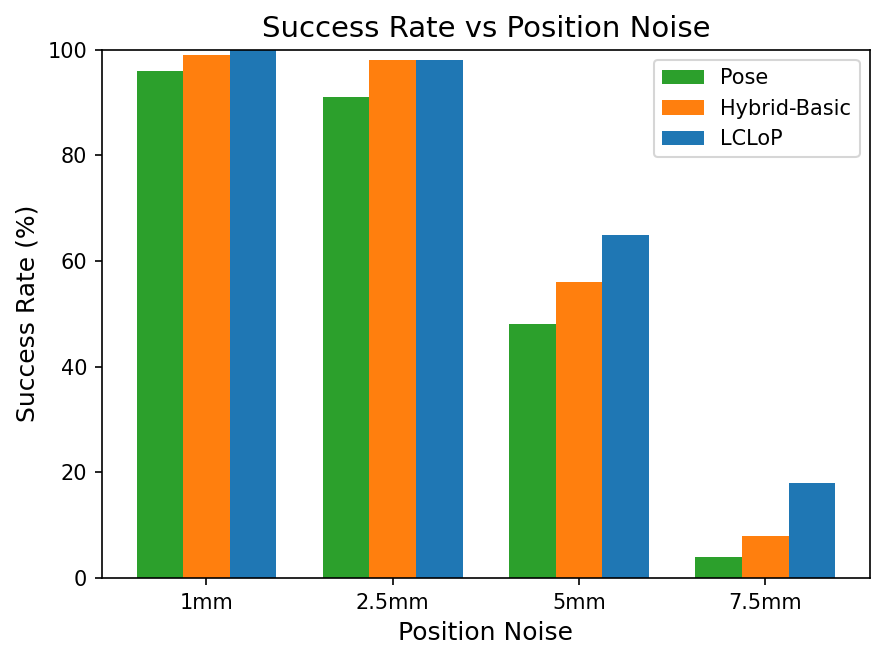

In [ ]:
# ============================================================
# BLOCK 4: SUCCESS RATE VS POSITION NOISE - BAR PLOT
# ============================================================

# Policy Selection
TOP_N_POLICIES = None  # Set to integer (e.g., 3) to use top N policies, or None for all

# Plot Constants
FIGSIZE = (6, 4.5)
DPI = 150
BAR_WIDTH = 0.25

# Colors (matching reference image)
COLORS = {
    "Pose": "#2ca02c",        # Green
    "Hybrid-Basic": "#ff7f0e", # Orange
    "LCLoP": "#1f77b4",       # Blue
}

# Font sizes
FONT_TITLE = 14
FONT_AXIS_LABEL = 12
FONT_TICK = 10
FONT_LEGEND = 10

# Axis configuration
Y_LIM = (0, 100)
Y_TICKS = [0, 20, 40, 60, 80, 100]

# Labels
TITLE = "Success Rate vs Position Noise"
X_LABEL = "Position Noise"
Y_LABEL = "Success Rate (%)"

# ============================================================

def filter_top_n_runs(df, best_checkpoints, top_n):
    """Filter dataframe to only include top N runs by score."""
    if top_n is None or len(best_checkpoints) <= top_n:
        return df
    sorted_runs = sorted(best_checkpoints.items(), key=lambda x: x[1]["score"], reverse=True)
    top_run_names = {info["run_name"] for _, info in sorted_runs[:top_n]}
    # Match by agent number
    top_agent_nums = {name.rsplit("_", 1)[-1] for name in top_run_names}
    return df[df["run_name"].apply(lambda x: x.rsplit("_", 1)[-1] in top_agent_nums)]

noise_labels = list(NOISE_LEVELS.keys())
x = np.arange(len(noise_labels))
method_names = list(METHOD_TAGS.keys())

fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

for i, method_name in enumerate(method_names):
    df = noise_data[method_name]
    df = filter_top_n_runs(df, best_checkpoints_by_method[method_name], TOP_N_POLICIES)
    means = []
    for noise_label in noise_labels:
        subset = df[df["noise_level"] == noise_label]
        if not subset.empty:
            total = subset["total"].sum()
            success_rate = 100 * subset["success"].sum() / total
            means.append(success_rate)
        else:
            means.append(0)
    
    offset = (i - len(method_names)/2 + 0.5) * BAR_WIDTH
    ax.bar(x + offset, means, BAR_WIDTH, label=method_name, color=COLORS[method_name])

ax.set_xlabel(X_LABEL, fontsize=FONT_AXIS_LABEL)
ax.set_ylabel(Y_LABEL, fontsize=FONT_AXIS_LABEL)
ax.set_title(TITLE, fontsize=FONT_TITLE)
ax.set_xticks(x)
ax.set_xticklabels(noise_labels, fontsize=FONT_TICK)
ax.set_ylim(Y_LIM)
ax.set_yticks(Y_TICKS)
ax.tick_params(axis='y', labelsize=FONT_TICK)
ax.legend(fontsize=FONT_LEGEND)

plt.tight_layout()
plt.show()

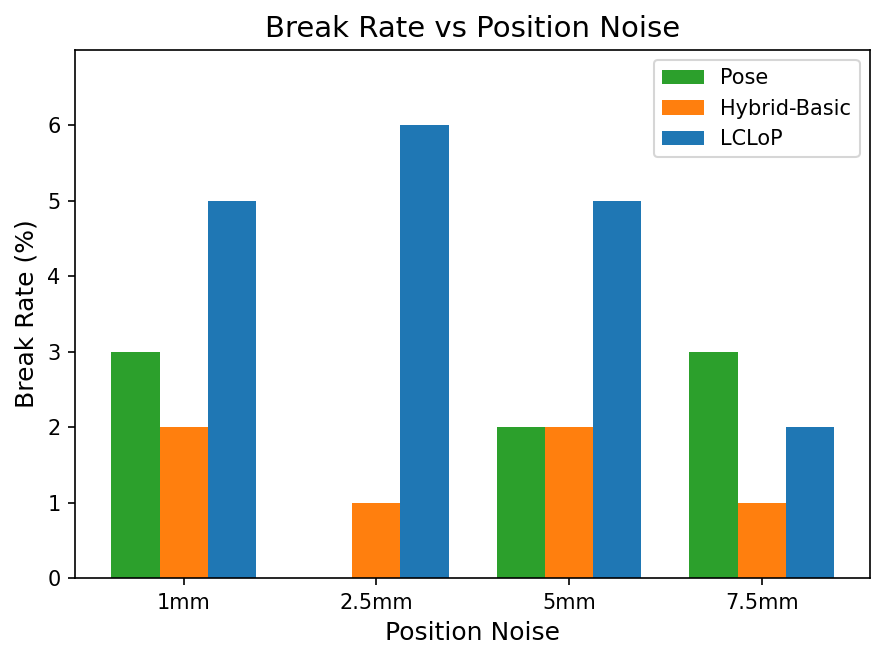

In [ ]:
# ============================================================
# BLOCK 5: BREAK RATE VS POSITION NOISE - BAR PLOT
# ============================================================

# Policy Selection
TOP_N_POLICIES = None  # Set to integer (e.g., 3) to use top N policies, or None for all

# Plot Constants
FIGSIZE = (6, 4.5)
DPI = 150
BAR_WIDTH = 0.25

# Colors
COLORS = {
    "Pose": "#2ca02c",
    "Hybrid-Basic": "#ff7f0e",
    "LCLoP": "#1f77b4",
}

# Font sizes
FONT_TITLE = 14
FONT_AXIS_LABEL = 12
FONT_TICK = 10
FONT_LEGEND = 10

# Axis configuration
Y_LIM = (0, 7)
Y_TICKS = [i for i in range(Y_LIM[-1])]

# Labels
TITLE = "Break Rate vs Position Noise"
X_LABEL = "Position Noise"
Y_LABEL = "Break Rate (%)"

# ============================================================

def filter_top_n_runs(df, best_checkpoints, top_n):
    """Filter dataframe to only include top N runs by score."""
    if top_n is None or len(best_checkpoints) <= top_n:
        return df
    sorted_runs = sorted(best_checkpoints.items(), key=lambda x: x[1]["score"], reverse=True)
    top_run_names = {info["run_name"] for _, info in sorted_runs[:top_n]}
    # Match by agent number
    top_agent_nums = {name.rsplit("_", 1)[-1] for name in top_run_names}
    return df[df["run_name"].apply(lambda x: x.rsplit("_", 1)[-1] in top_agent_nums)]

noise_labels = list(NOISE_LEVELS.keys())
x = np.arange(len(noise_labels))
method_names = list(METHOD_TAGS.keys())

fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

for i, method_name in enumerate(method_names):
    df = noise_data[method_name]
    df = filter_top_n_runs(df, best_checkpoints_by_method[method_name], TOP_N_POLICIES)
    means = []
    for noise_label in noise_labels:
        subset = df[df["noise_level"] == noise_label]
        if not subset.empty:
            total = subset["total"].sum()
            break_rate = 100 * subset["breaks"].sum() / total
            means.append(break_rate)
        else:
            means.append(0)
    
    offset = (i - len(method_names)/2 + 0.5) * BAR_WIDTH
    ax.bar(x + offset, means, BAR_WIDTH, label=method_name, color=COLORS[method_name])

ax.set_xlabel(X_LABEL, fontsize=FONT_AXIS_LABEL)
ax.set_ylabel(Y_LABEL, fontsize=FONT_AXIS_LABEL)
ax.set_title(TITLE, fontsize=FONT_TITLE)
ax.set_xticks(x)
ax.set_xticklabels(noise_labels, fontsize=FONT_TICK)
ax.set_ylim(Y_LIM)
ax.set_yticks(Y_TICKS)
ax.tick_params(axis='y', labelsize=FONT_TICK)
ax.legend(fontsize=FONT_LEGEND)

plt.tight_layout()
plt.show()

In [23]:
# ============================================================
# BLOCK 6: LATEX TABLE - NOMINAL PERFORMANCE
# ============================================================

# Policy Selection
TOP_N_POLICIES = None  # Set to integer (e.g., 3) to use top N policies, or None for all

# Table Configuration
TABLE_CAPTION = "Nominal performance on FPiH with round peg at 1mm training noise. Results averaged over 5 seeds. Best performance per metric in \\textbf{bold}."
TABLE_LABEL = "tab:nominal_performance"

# Column formatting
DECIMAL_PLACES = 1

# Metrics: (display_name, higher_is_better)
TABLE_METRICS = [
    ("Success", True),
    ("Break", False),
    ("Time (s)", False),
    ("Force (N)", False),
]

# ============================================================

def filter_top_n_runs_perf(df, best_checkpoints, top_n):
    """Filter dataframe to only include top N runs by score."""
    if top_n is None or len(best_checkpoints) <= top_n:
        return df
    sorted_runs = sorted(best_checkpoints.items(), key=lambda x: x[1]["score"], reverse=True)
    top_run_ids = {run_id for run_id, _ in sorted_runs[:top_n]}
    return df[df["run_id"].isin(top_run_ids)]

def format_mean_std(mean, std, decimal=1):
    return f"{mean:.{decimal}f} $\\pm$ {std:.{decimal}f}"

def bold_if_best(value_str, is_best):
    if is_best:
        return f"\\textbf{{{value_str}}}"
    return value_str

# Compute statistics for each method
stats = {}
for method_name, df in perf_data.items():
    if df.empty:
        continue
    
    # Filter to top N if specified
    df = filter_top_n_runs_perf(df, best_checkpoints_by_method[method_name], TOP_N_POLICIES)
    
    # Calculate per-run rates
    df = df.copy()
    df["success_rate"] = 100 * df["success"] / df["total"]
    df["break_rate"] = 100 * df["breaks"] / df["total"]
    
    stats[method_name] = {
        "Success": (df["success_rate"].mean(), df["success_rate"].std()),
        "Break": (df["break_rate"].mean(), df["break_rate"].std()),
        "Time (s)": (df["time"].mean(), df["time"].std()),
        "Force (N)": (df["force"].mean(), df["force"].std()),
    }

# Determine best values
best_values = {}
for metric, higher_is_better in TABLE_METRICS:
    means = [(method, stats[method][metric][0]) for method in stats]
    if higher_is_better:
        best_method = max(means, key=lambda x: x[1])[0]
    else:
        best_method = min(means, key=lambda x: x[1])[0]
    best_values[metric] = best_method

# Generate LaTeX
UP_ARROW = "$\\uparrow$"
DOWN_ARROW = "$\\downarrow$"
header_parts = [f"{m} {UP_ARROW if h else DOWN_ARROW}" for m, h in TABLE_METRICS]
header_row = "Method & " + " & ".join(header_parts) + " \\\\"

latex_lines = [
    "\\begin{table}[t]",
    "\\centering",
    f"\\caption{{{TABLE_CAPTION}}}",
    f"\\label{{{TABLE_LABEL}}}",
    "\\begin{tabular}{l" + "c" * len(TABLE_METRICS) + "}",
    "\\toprule",
    header_row,
    "\\midrule",
]

for method_name in METHOD_TAGS.keys():
    if method_name not in stats:
        continue
    
    cells = [method_name]
    for metric, _ in TABLE_METRICS:
        mean, std = stats[method_name][metric]
        value_str = format_mean_std(mean, std, DECIMAL_PLACES)
        is_best = (best_values[metric] == method_name)
        cells.append(bold_if_best(value_str, is_best))
    
    latex_lines.append(" & ".join(cells) + " \\\\")

latex_lines.extend([
    "\\bottomrule",
    "\\end{tabular}",
    "\\end{table}",
])

latex_output = "\n".join(latex_lines)
print(latex_output)

\begin{table}[t]
\centering
\caption{Nominal performance on FPiH with round peg at 1mm training noise. Results averaged over 5 seeds. Best performance per metric in \textbf{bold}.}
\label{tab:nominal_performance}
\begin{tabular}{lcccc}
\toprule
Method & Success $\uparrow$ & Break $\downarrow$ & Time (s) $\downarrow$ & Force (N) $\downarrow$ \\
\midrule
Pose & 95.8 $\pm$ 2.4 & 0.6 $\pm$ 0.9 & 149.2 $\pm$ 1.2 & \textbf{2.5 $\pm$ 0.2} \\
Hybrid-Basic & \textbf{96.2 $\pm$ 1.9} & \textbf{0.2 $\pm$ 0.4} & 149.8 $\pm$ 0.5 & 3.4 $\pm$ 0.2 \\
LCLoP & 95.8 $\pm$ 2.2 & 1.0 $\pm$ 1.7 & \textbf{148.8 $\pm$ 2.3} & 3.3 $\pm$ 0.4 \\
\bottomrule
\end{tabular}
\end{table}
